In [253]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt

In [264]:
# Loading the train file, split in 2
train_data1 = pd.read_csv('train_data1.csv', sep=',')
train_data2 = pd.read_csv('train_data2.csv', sep=',', skiprows=1, header=None)

In [265]:
# Creating DF with features and duplicate variable only for final model
def append_df(df1, df2):
    # df1 with column names, and df2 without
    remove_cols = ['id','qid1','qid2','question1','question2','question1_form','question2_form']
    df2.columns = df1.columns
    df1.drop(remove_cols, inplace=True, axis=1)
    df2.drop(remove_cols, inplace=True, axis=1)
    df1 = df1.append(df2, ignore_index=True)
    return df1

In [266]:
train_data1 = append_df(train_data1,train_data2) 

In [267]:
# Check the feature values for any kind of imputation
train_data1.count()

is_duplicate       404290
q1_form_len        404290
q2_form_len        404290
q1_length          404290
q2_length          404290
q1_unique          404290
q2_unique          404290
q1_form_uni        404290
q2_form_uni        404290
q1_form_char       404290
q2_form_char       404290
q1_q2_char_diff    404290
common_cnt         404290
prcnt_common       404218
dtype: int64

In [268]:
train_data1['prcnt_common'].fillna(train_data1['prcnt_common'].mean(), inplace=True)

In [269]:
train_data1.count()

is_duplicate       404290
q1_form_len        404290
q2_form_len        404290
q1_length          404290
q2_length          404290
q1_unique          404290
q2_unique          404290
q1_form_uni        404290
q2_form_uni        404290
q1_form_char       404290
q2_form_char       404290
q1_q2_char_diff    404290
common_cnt         404290
prcnt_common       404290
dtype: int64

In [270]:
val_dup = train_data1["is_duplicate"]
train_data1.drop(['is_duplicate'], axis=1, inplace=True)

In [271]:
val_dup = pd.DataFrame(pd.Series(val_dup))

In [272]:
# Separate into Train and Validation
from sklearn.cross_validation import train_test_split
X_train, X_val, Y_train, Y_val = sklearn.cross_validation.train_test_split(train_data1, val_dup, 
                                                                           test_size = 0.2, random_state = 5)

In [273]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric='auc')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(Y_train), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [274]:
# xgboost classifier : Using the best params from the first iteration of the Basic Features Model
xgb1 = XGBClassifier(max_depth= 3, min_child_weight= 10,gamma=0.1 ,colsample_bytree=0.4 , subsample=0.9 , reg_alpha = 0.1, 
                     reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, 
                     objective= 'binary:logistic', nthread=4, seed=45)

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.775049


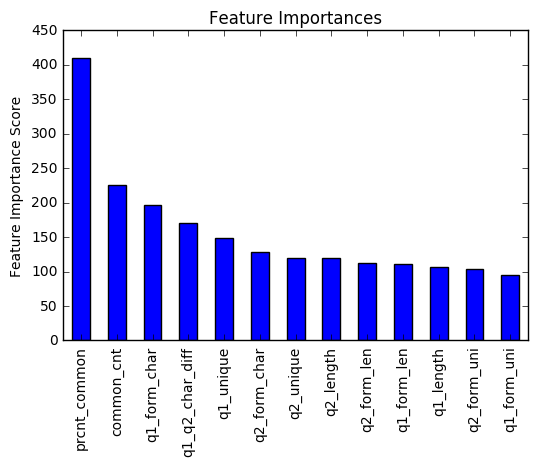

In [275]:
predictors  = list(X_train.columns)
modelfit(xgb1, X_train, predictors)

In [276]:
# Train roc auc
y_predS = xgb1.predict_proba(X_train)
roc_auc_score(Y_train, y_predS[:,1])

0.7750494041207755

In [277]:
# Cross validation AUC
cv_score = cross_val_score(xgb1, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score.mean()))
print('std auc: ' + str(cv_score.std()))

mean auc: 0.774066846929
std auc: 0.00140766666008


In [278]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb1, '/home/pgoyal/quora/model/xgb_dup_auc.pkl')

['/home/pgoyal/quora/model/xgb_dup_auc.pkl',
 '/home/pgoyal/quora/model/xgb_dup_auc.pkl_01.npy']

In [279]:
# Validation AUC
val_pred = xgb1.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred[:,1])))

Validation AUC: 0.772071419197


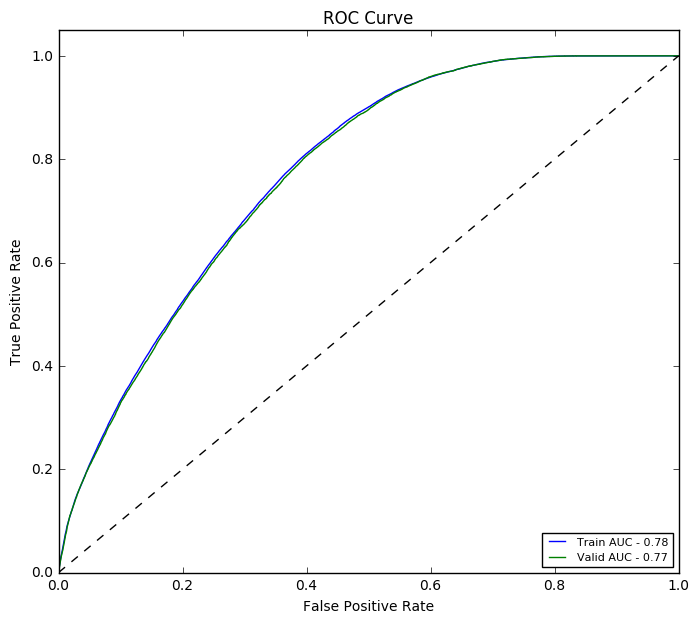

In [280]:
# Make ROC curve for train and validation
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [281]:
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

In [282]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[2, 3, 4, 5, 6],
   'min_child_weight':[1, 2, 3, 4, 5, 6, 10, 15, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth= 3, min_child_weight= 10,gamma=0.1 ,colsample_bytree=0.4 , subsample=0.9 , reg_alpha = 0.1, 
                     reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, 
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search1.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.76559, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.76559, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.76558, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.76558, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.76558, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.76559, std: 0.00128, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.76552, std: 0.00119, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: 0.76565, std: 0.00120, params: {'max_depth': 2, 'min_child_weight': 15},
  mean: 0.76571, std: 0.00125, params: {'max_depth': 2, 'min_child_weight': 100},
  mean: 0.77407, std: 0.00128, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.77404, std: 0.00131, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.77399, std: 0.00128, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.77395, std: 0.00123, param

In [283]:
# Best till here : Order is on the basis of the params given!
new_max_depth = gsearch1.best_params_.values()[0]
new_min_child_weight = gsearch1.best_params_.values()[1]

In [284]:
# Tune tree pruning parameters: gamma
param_test2 = {
   'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                        gamma=0.1 ,colsample_bytree=0.4 , subsample=0.9 , reg_alpha = 0.1, 
                        reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, 
                        objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch2.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search2.csv')
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78815, std: 0.00160, params: {'gamma': 0.0},
  mean: 0.78836, std: 0.00150, params: {'gamma': 0.1},
  mean: 0.78834, std: 0.00136, params: {'gamma': 0.2},
  mean: 0.78839, std: 0.00154, params: {'gamma': 0.3},
  mean: 0.78831, std: 0.00155, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.78839481002208256)

In [285]:
# Best till here :
new_gamma = gsearch2.best_params_.values()[0]

In [286]:
# Tune tree pruning parameters: subsample, colsample_bytree
param_test3 = {
  'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma ,colsample_bytree=0.4 , subsample=0.9 , reg_alpha = 0.1, 
                     reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, 
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch3.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search3.csv')
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.78831, std: 0.00149, params: {'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: 0.78853, std: 0.00147, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.78844, std: 0.00144, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.78839, std: 0.00154, params: {'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: 0.78909, std: 0.00150, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: 0.78926, std: 0.00160, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: 0.78908, std: 0.00149, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: 0.78893, std: 0.00135, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: 0.78973, std: 0.00153, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.78996, std: 0.00147, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.78972, std: 0.00149, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.78958, std: 0.00127, params: {'subsample': 0.9, 'colsample_bytree'

In [287]:
# Best till here :
new_subsample = gsearch3.best_params_.values()[0]
new_colsample_bytree = gsearch3.best_params_.values()[1]

In [288]:
# Tune tree pruning parameters: reg_alpha
param_test4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma,colsample_bytree=new_colsample_bytree, subsample=new_subsample, reg_alpha = 0.1, 
                     reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, 
                     objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch4.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search4.csv')
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.79110, std: 0.00158, params: {'reg_alpha': 1e-05},
  mean: 0.79105, std: 0.00145, params: {'reg_alpha': 0.01},
  mean: 0.79123, std: 0.00156, params: {'reg_alpha': 0.1},
  mean: 0.79124, std: 0.00160, params: {'reg_alpha': 1},
  mean: 0.78225, std: 0.00127, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.79123861431771936)

In [289]:
# Best till here :
new_reg_alpha= gsearch4.best_params_.values()[0]

In [290]:
# Tune tree pruning parameters: reg_lambda
param_test5 = {
  'reg_lambda':[0, 1, 1.1, 1.2, 1.5, 2, 3, 5]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = 1, max_delta_step = 0 , scale_pos_weight= 1, 
                    learning_rate = 0.05, n_estimators=300, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch5.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search5.csv')
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.79141, std: 0.00152, params: {'reg_lambda': 0},
  mean: 0.79124, std: 0.00160, params: {'reg_lambda': 1},
  mean: 0.79132, std: 0.00147, params: {'reg_lambda': 1.1},
  mean: 0.79132, std: 0.00141, params: {'reg_lambda': 1.2},
  mean: 0.79126, std: 0.00153, params: {'reg_lambda': 1.5},
  mean: 0.79114, std: 0.00162, params: {'reg_lambda': 2},
  mean: 0.79101, std: 0.00152, params: {'reg_lambda': 3},
  mean: 0.79075, std: 0.00152, params: {'reg_lambda': 5}],
 {'reg_lambda': 0},
 0.79140906743100581)

In [291]:
# Best till here :
new_reg_lambda= gsearch5.best_params_.values()[0]

In [292]:
# Tune tree pruning parameters: max_delta_step
param_test6 = {
  'max_delta_step':[0, 1, 2, 3, 4, 5, 10, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = 0 , scale_pos_weight= 1, 
                    learning_rate = 0.05, n_estimators=300, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch6.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search6.csv')
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.79141, std: 0.00152, params: {'max_delta_step': 0},
  mean: 0.79082, std: 0.00144, params: {'max_delta_step': 1},
  mean: 0.79139, std: 0.00150, params: {'max_delta_step': 2},
  mean: 0.79141, std: 0.00158, params: {'max_delta_step': 3},
  mean: 0.79141, std: 0.00152, params: {'max_delta_step': 4},
  mean: 0.79141, std: 0.00152, params: {'max_delta_step': 5},
  mean: 0.79141, std: 0.00152, params: {'max_delta_step': 10},
  mean: 0.79141, std: 0.00152, params: {'max_delta_step': 100}],
 {'max_delta_step': 3},
 0.79141322444699436)

In [293]:
# Best till here :
new_max_delta_step= gsearch6.best_params_.values()[0]

In [294]:
# Tune tree pruning parameters: scale_pos_weight
param_test7 = {
  'scale_pos_weight':[0, 1, 2, 5, 10, 50, 100]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = new_max_delta_step , 
                    scale_pos_weight= 1, learning_rate = 0.05, n_estimators=300, objective= 'binary:logistic', 
                    nthread=4, seed=45), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch7.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search7.csv')
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.50000, std: 0.00000, params: {'scale_pos_weight': 0},
  mean: 0.79141, std: 0.00158, params: {'scale_pos_weight': 1},
  mean: 0.79149, std: 0.00158, params: {'scale_pos_weight': 2},
  mean: 0.79063, std: 0.00147, params: {'scale_pos_weight': 5},
  mean: 0.78975, std: 0.00151, params: {'scale_pos_weight': 10},
  mean: 0.78640, std: 0.00153, params: {'scale_pos_weight': 50},
  mean: 0.78501, std: 0.00153, params: {'scale_pos_weight': 100}],
 {'scale_pos_weight': 2},
 0.79148501751351352)

In [295]:
# Best till here :
new_scale_pos_weight= gsearch7.best_params_.values()[0]

In [296]:
param_test8 = {
    'learning_rate':[0.03, 0.05],
    'n_estimators':[250, 300, 350, 500, 700]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier(max_depth= new_max_depth, min_child_weight= new_min_child_weight,
                    gamma=new_gamma, colsample_bytree=new_colsample_bytree, subsample=new_subsample, 
                    reg_alpha = new_reg_alpha, reg_lambda = new_reg_lambda, max_delta_step = new_max_delta_step , 
                    scale_pos_weight= new_scale_pos_weight, learning_rate = 0.05, n_estimators=300,
                    objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch8.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch8.grid_scores_).to_csv('/home/pgoyal/quora/model/gs_files/gs_search8.csv')
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.78452, std: 0.00135, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: 0.78651, std: 0.00133, params: {'n_estimators': 300, 'learning_rate': 0.03},
  mean: 0.78823, std: 0.00132, params: {'n_estimators': 350, 'learning_rate': 0.03},
  mean: 0.79151, std: 0.00140, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: 0.79413, std: 0.00137, params: {'n_estimators': 700, 'learning_rate': 0.03},
  mean: 0.78989, std: 0.00152, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: 0.79149, std: 0.00158, params: {'n_estimators': 300, 'learning_rate': 0.05},
  mean: 0.79261, std: 0.00153, params: {'n_estimators': 350, 'learning_rate': 0.05},
  mean: 0.79523, std: 0.00169, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: 0.79736, std: 0.00162, params: {'n_estimators': 700, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 700},
 0.79735789061544282)

In [297]:
# Best till here :
new_learning_rate= gsearch8.best_params_.values()[0]
new_n_estimators= gsearch8.best_params_.values()[1]

In [ ]:
# Using the final param values from the above GridSearch
# Make this var in the below model call : Check!

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.813325


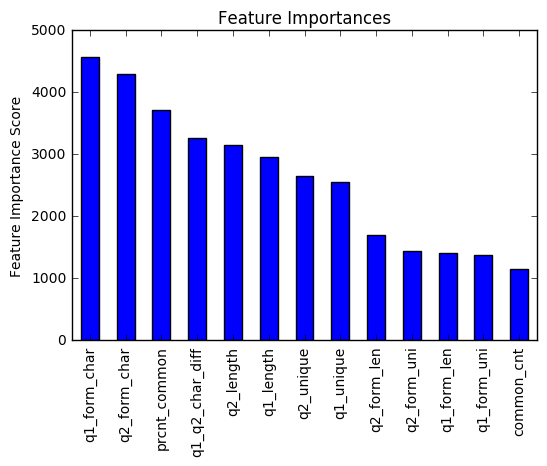

In [298]:
# Final xgboost classifier with updated params
xgb2 = XGBClassifier( max_depth= 6, min_child_weight= 2,gamma=0.3, colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
modelfit(xgb2, X_train, predictors)

In [299]:
# Train roc_auc
y_predS_xgb2 = xgb2.predict_proba(X_train)
roc_auc_score(Y_train, y_predS_xgb2[:,1])

0.8133254919401991

In [315]:
# Cross validation AUC 
cv_score_xgb2 = cross_val_score(xgb2, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_xgb2.mean()))
print('std auc: ' + str(cv_score_xgb2.std()))

mean auc: 0.797357890615
std auc: 0.00162471560154


In [301]:
# Save the model
from sklearn.externals import joblib
# Model-1 (without prcnt_common feature)
#joblib.dump(xgb2, '/home/pgoyal/quora/model/xgb2_dup_auc.pkl')
# Model-2 (with prcnt_common feature)
joblib.dump(xgb2, '/home/pgoyal/quora/model/xgb2_dup_auc_2.pkl')

['/home/pgoyal/quora/model/xgb2_dup_auc_2.pkl',
 '/home/pgoyal/quora/model/xgb2_dup_auc_2.pkl_01.npy']

## Decile Info - Train

In [302]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS_xgb2[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [303]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,32343,25225.0,7118.0,0.210941,0.779921,0.034918,0.210941,0.034918,0.467041,2.109427
1,32343,20695.0,11648.0,0.173060,0.639860,0.057141,0.384001,0.092059,0.467041,1.920017
2,32343,18349.0,13994.0,0.153442,0.567325,0.068650,0.537443,0.160709,0.467041,1.791486
3,32343,16306.0,16037.0,0.136357,0.504159,0.078672,0.673800,0.239381,0.467041,1.684510
4,32343,14417.0,17926.0,0.120561,0.445753,0.087939,0.794360,0.327319,0.467041,1.588731
5,32343,11858.0,20485.0,0.099161,0.366633,0.100492,0.893522,0.427811,0.467041,1.489212
6,32343,8461.0,23882.0,0.070754,0.261602,0.117156,0.964276,0.544968,0.467041,1.377545
7,32343,3818.0,28525.0,0.031928,0.118047,0.139933,0.996203,0.684901,0.467041,1.245262
8,32343,454.0,31889.0,0.003797,0.014037,0.156436,1.000000,0.841337,0.467041,1.111118
9,32343,0.0,32343.0,0.000000,0.000000,0.158663,1.000000,1.000000,0.467041,1.000006


Probability from classifier for Train
Response 10%: 0.779921466778
Capture at 10%: 0.21094135454
Response 5%: 0.826603178529
Capture at 5%: 0.111780102523


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f600bc97b50>)

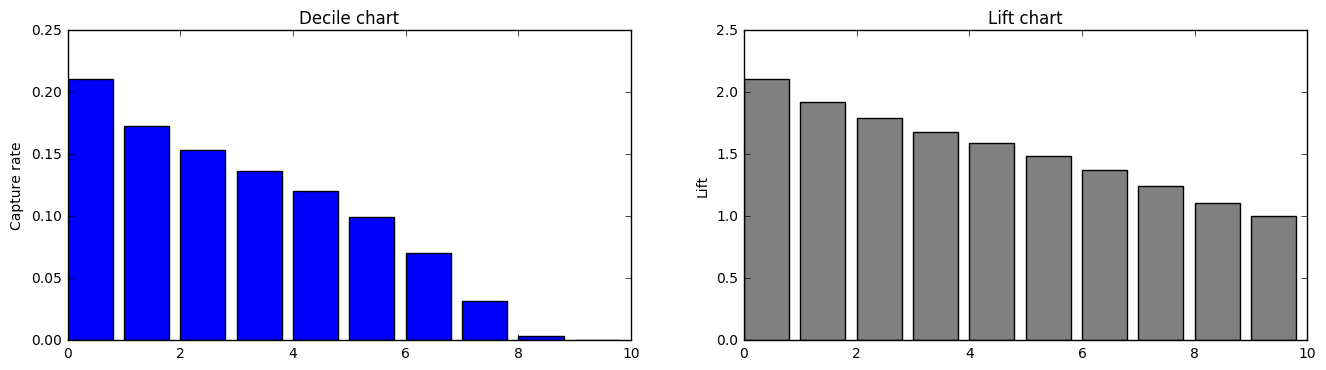

In [304]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Train' 
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

## Decile Info - Validation

In [305]:
# Validation AUC
val_pred_xgb2 = xgb2.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred_xgb2[:,1])))

Validation AUC: 0.796158536879


In [306]:
# Decile related info
df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(val_pred_xgb2[:,1]) 
prob.columns = ['Probability']
prob["Target"] = Y_val.values 
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [307]:
# Decile info dataframe
df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,8085,6079.0,2006.0,0.204818,0.751886,0.039203,0.204818,0.039203,0.440949,2.048383
1,8085,4905.0,3180.0,0.165263,0.606679,0.062146,0.370081,0.101348,0.440949,1.850587
2,8085,4512.0,3573.0,0.152022,0.558071,0.069826,0.522102,0.171175,0.440949,1.740514
3,8085,4035.0,4050.0,0.135950,0.499072,0.079148,0.658053,0.250322,0.440949,1.645294
4,8085,3548.0,4537.0,0.119542,0.438837,0.088665,0.777594,0.338988,0.440949,1.555343
5,8085,3012.0,5073.0,0.101482,0.372542,0.099140,0.879077,0.438128,0.440949,1.465273
6,8085,2188.0,5897.0,0.073720,0.270625,0.115243,0.952796,0.553371,0.440949,1.361273
7,8085,1175.0,6910.0,0.039589,0.145331,0.135040,0.992385,0.688411,0.440949,1.240605
8,8085,225.0,7860.0,0.007581,0.027829,0.153606,0.999966,0.842017,0.440949,1.111184
9,8085,1.0,8084.0,0.000034,0.000124,0.157983,1.000000,1.000000,0.440949,1.000099


Probability from classifier for Validation
Response 10%: 0.751886209029
Capture at 10%: 0.204818059299
Response 5%: 0.802820385948
Capture at 5%: 0.109332884097


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f6012015cd0>)

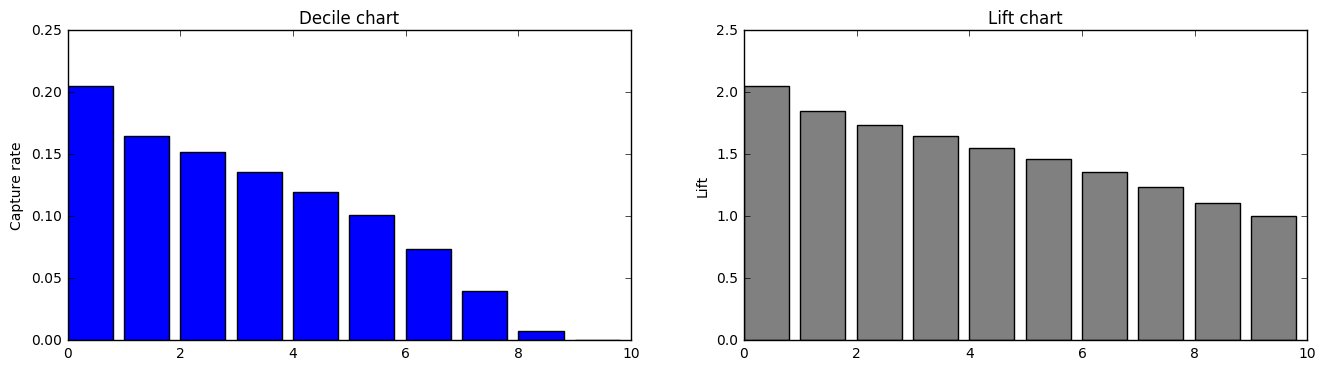

In [308]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Validation'
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

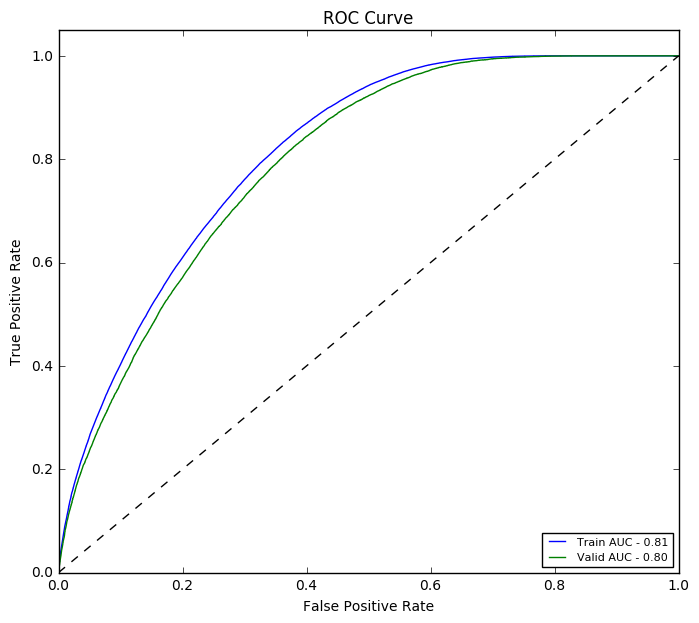

In [309]:
# Make ROC curve for train and validation as of now
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS_xgb2[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred_xgb2[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)
# print roc_auc

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)   # Valid or Test ???
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [310]:
feat_imp = pd.Series(xgb2.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [311]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,q1_form_char,4575,0.133506
1,q2_form_char,4300,0.125481
2,prcnt_common,3715,0.108410
3,q1_q2_char_diff,3272,0.095483
4,q2_length,3157,0.092127
5,q1_length,2961,0.086407
6,q2_unique,2652,0.077390
7,q1_unique,2558,0.074647
8,q2_form_len,1693,0.049405
9,q2_form_uni,1443,0.042109


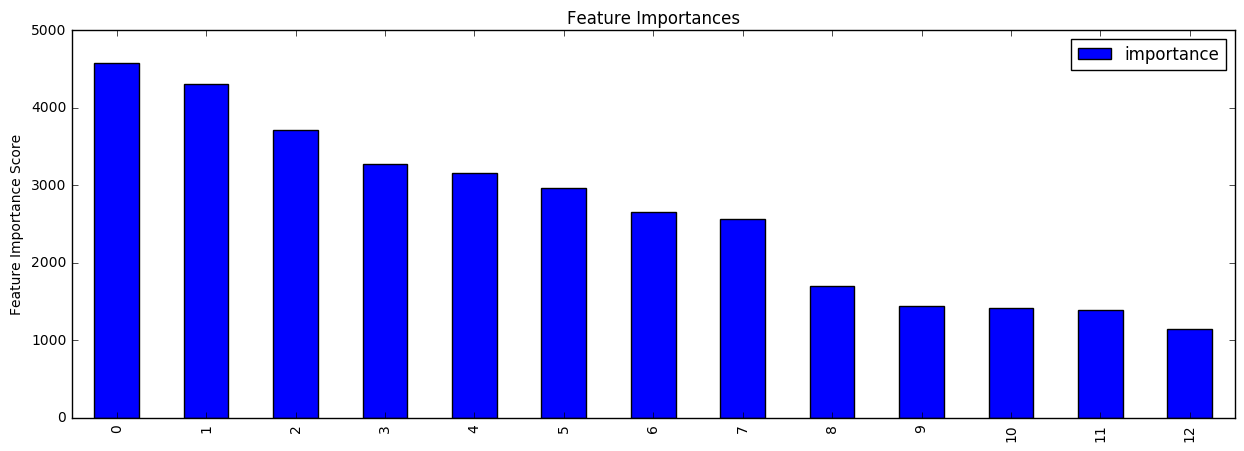

In [312]:
feat_imp[['features','importance']].plot(kind='bar', title='Feature Importances', figsize=(15,5))
plt.ylabel('Feature Importance Score')

In [313]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

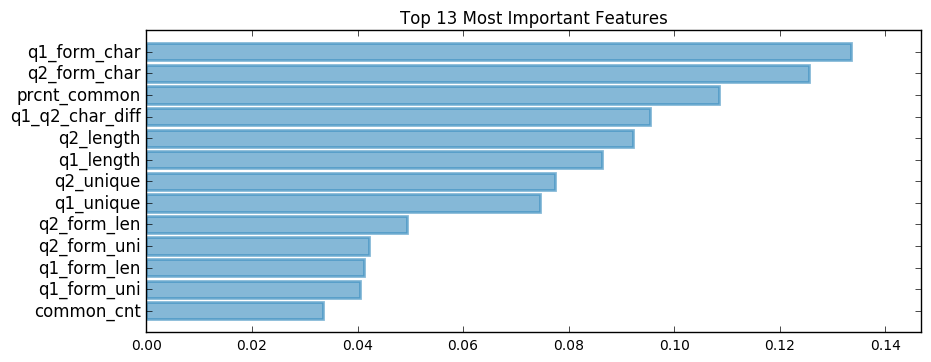

In [314]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [ ]:
# Add Extra features here : 1. TF-IDF , 2. Fuzzywuzzy , 3. 